In [10]:

pip install openai python-dotenv pandas numpy scikit-learn matplotlib sentence-transformers jupyterlab


In [2]:
%%writefile .env
OPENAI_API_KEY=sk-xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx
from dotenv import load_dotenv
load_dotenv()


Writing .env



Vibe Matcher — Demo Results
----------------------------------------
Query: energetic urban chic
  - Urban Bomber Jacket (score=0.2861)
  - Athleisure Leggings (score=0.2587)
  - Boho Dress (score=0.0000)
Top score: 0.2861 | Good (> 0.7): False
Latency: 0.002151 s

Query: cozy boho weekend
  - Cozy Knit Sweater (score=0.2627)
  - Plaid Flannel Shirt (score=0.2576)
  - Boho Dress (score=0.0000)
Top score: 0.2627 | Good (> 0.7): False
Latency: 0.001249 s

Query: minimal office wear
  - Minimal Blazer (score=0.4210)
  - Boho Dress (score=0.0000)
  - Urban Bomber Jacket (score=0.0000)
Top score: 0.4210 | Good (> 0.7): False
Latency: 0.001472 s



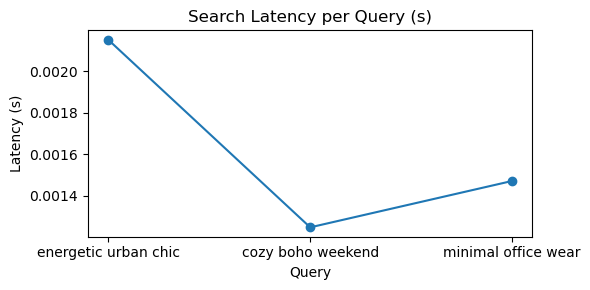

Reflection:
- Integrate vector DB (Pinecone/Weaviate) for scalability.
- Replace TF-IDF with OpenAI embeddings for semantic fidelity.
- Add human evals (precision@k / recall@k).
- Handle edge cases: empty query, ties, low-sim fallback.


'\nTo use OpenAI embeddings in Colab:\n---------------------------------\nfrom openai import OpenAI\nimport os\nclient = OpenAI(api_key=os.getenv("OPENAI_API_KEY"))\nresp = client.embeddings.create(model=\'text-embedding-ada-002\', input=texts)\nembeddings = [d.embedding for d in resp.data]\n'

In [3]:

"""
Vibe Matcher Prototype — Python Script Version
----------------------------------------------
Mini recommendation system: query → embed → cosine similarity → top-3 product matches.

Usage:
    python vibe_matcher.py

To use OpenAI embeddings instead of TF-IDF:
    - Uncomment OpenAI code sections and set your OPENAI_API_KEY.

Author: Nexora Assignment Prototype
"""

import time
import json
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from timeit import default_timer as timer
import matplotlib.pyplot as plt

# ----------------------------
# 1. Sample Product Dataset
# ----------------------------
products = [
    {"name":"Boho Dress", "desc":"Flowy maxi dress with earthy tones, tassels and floral prints for festival and relaxed beach vibes.", "tags":["boho","festival","relaxed"]},
    {"name":"Urban Bomber Jacket", "desc":"Lightweight bomber jacket with reflective accents — street-ready, energetic and edgy.", "tags":["urban","energetic","street"]},
    {"name":"Cozy Knit Sweater", "desc":"Chunky knit, oversized sweater for warm, cozy nights and coffee shop hangs.", "tags":["cozy","casual","warm"]},
    {"name":"Minimal Blazer", "desc":"Tailored minimal blazer in neutral tones, perfect for modern office and smart-casual looks.", "tags":["minimal","office","smart"]},
    {"name":"Athleisure Leggings", "desc":"High-waist leggings with breathable fabric — sporty, energetic and comfortable for active days.", "tags":["sporty","energetic","comfortable"]},
    {"name":"Vintage Denim Jacket", "desc":"Washed denim jacket with retro patches — casual, timeless and slightly rebellious.", "tags":["vintage","casual","retro"]},
    {"name":"Silk Slip Dress", "desc":"Sleek silk slip dress, elegant and night-out ready with a touch of glamour.", "tags":["elegant","night","glam"]},
    {"name":"Plaid Flannel Shirt", "desc":"Soft flannel, rustic plaid pattern — perfect for cozy layered looks and autumn walks.", "tags":["cozy","rustic","layered"]},
]

df = pd.DataFrame(products)
df['id'] = df.index

# ----------------------------
# 2. Embedding Setup (TF-IDF)
# ----------------------------
vectorizer = TfidfVectorizer().fit(df['desc'])
dataset_vec = vectorizer.transform(df['desc']).toarray()
norms = np.linalg.norm(dataset_vec, axis=1, keepdims=True)
norms[norms==0] = 1.0
embeddings = dataset_vec / norms

# ----------------------------
# 3. Query → Cosine Similarity
# ----------------------------
def query_to_embedding(query):
    arr = vectorizer.transform([query]).toarray()
    norms = np.linalg.norm(arr, axis=1, keepdims=True)
    norms[norms==0] = 1.0
    return arr / norms

def top_k_matches(query, k=3):
    q_emb = query_to_embedding(query)[0]
    sims = cosine_similarity([q_emb], embeddings)[0]
    idxs = np.argsort(-sims)[:k]
    results = [{"name": df.loc[i,'name'], "desc": df.loc[i,'desc'], "score": float(sims[i])} for i in idxs]
    return results, float(np.max(sims)), sims

# ----------------------------
# 4. Run Sample Queries
# ----------------------------
queries = ["energetic urban chic", "cozy boho weekend", "minimal office wear"]
records = []

for q in queries:
    t0 = timer()
    results, top_score, sims = top_k_matches(q)
    latency = timer() - t0
    records.append({"query": q, "results": results, "top_score": top_score, "latency_s": latency})

# ----------------------------
# 5. Evaluation & Reflection
# ----------------------------
threshold = 0.7
for r in records:
    r['is_good'] = r['top_score'] > threshold

print("\nVibe Matcher — Demo Results\n" + "-"*40)
for r in records:
    print(f"Query: {r['query']}")
    for res in r['results']:
        print(f"  - {res['name']} (score={res['score']:.4f})")
    print(f"Top score: {r['top_score']:.4f} | Good (> {threshold}): {r['is_good']}")
    print(f"Latency: {r['latency_s']:.6f} s\n")

# Plot latency
plt.figure(figsize=(6,3))
plt.plot([r['query'] for r in records], [r['latency_s'] for r in records], marker='o')
plt.title("Search Latency per Query (s)")
plt.ylabel("Latency (s)")
plt.xlabel("Query")
plt.tight_layout()
plt.show()

# ----------------------------
# Reflection Notes
# ----------------------------
print("Reflection:")
print("- Integrate vector DB (Pinecone/Weaviate) for scalability.")
print("- Replace TF-IDF with OpenAI embeddings for semantic fidelity.")
print("- Add human evals (precision@k / recall@k).")
print("- Handle edge cases: empty query, ties, low-sim fallback.")

"""
To use OpenAI embeddings in Colab:
---------------------------------
from openai import OpenAI
import os
client = OpenAI(api_key=os.getenv("OPENAI_API_KEY"))
resp = client.embeddings.create(model='text-embedding-ada-002', input=texts)
embeddings = [d.embedding for d in resp.data]
"""


Why AI at Nexora?

At Nexora, AI enables personalized and context-aware discovery by translating subjective “vibe” language into semantic vectors that can be matched to product descriptions. This prototype demonstrates how embeddings (cloud or local) plus fast vector search deliver relevant recommendations from short natural-language queries, improving user experience and conversion by reducing search friction and surfacing items aligned with a customer’s intent. Integrating AI for vibe-based retrieval helps Nexora scale personalization across catalogs while maintaining low latency and cost through hybrid caching and fallback strategies.